In [1]:
import pandas as pd

# Load dataset
train_data = pd.read_csv("train_stock_news.csv")
test_data = pd.read_csv("test_stock_news.csv")

In [4]:
pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   - -------------------------------------- 10.0/203.0 MB 62.2 MB/s eta 0:00:04
   ----- ---------------------------------- 25.4/203.0 MB 67.1 MB/s eta 0:00:03
   -------- ------------------------------- 41.2/203.0 MB 70.8 MB/s eta 0:00:03
   ----------- ---------------------------- 57.4/203.0 MB 73.2 MB/s eta 0:00:02
   -------------- ------------------------- 73.4/203.0 MB 74.3 MB/s eta 0:00:02
   ----------------- ---------------------- 87.8/203.0 MB 73.8 MB/s eta 0:00:02
   ------------------ --------------------- 96.2/203.0 MB 69.0 MB/s eta 0:00:02
   -------------------- ------------------ 105.9/203.0 MB 65.7 MB/s eta 0:00:02
   ---------------------- ---------------- 114.8/203.0 MB 63.2 MB/s eta 0:00:02
   ----------------------- --------------- 124.8/203.0 MB 61.8 MB/s eta 0:00:02
   ------------------------- ------------- 132.4/203.0 MB 59.6 MB/s eta 0:00:02
   --------------------------- ----------- 140.8/

In [6]:
pip install transformers

  Using cached safetensors-0.4.5-cp312-none-win_amd64.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/10.0 MB ? eta -:--:--
   ---------------------------------------  10.0/10.0 MB 56.4 MB/s eta 0:00:01
   ---------------------------------------- 10.0/10.0 MB 52.0 MB/s eta 0:00:00
Using cached safetensors-0.4.5-cp312-none-win_amd64.whl (286 kB)
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 132.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import re
import torch
from transformers import BertTokenizer, BertModel
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AdamW

# Initialize tokenizer and base model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
base_model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to extract entities manually
def extract_gist(text, date):
    # Define regex patterns for dates, company names, and events
    date_pattern = r"\b\d{4}-\d{2}-\d{2}\b"  # Matches YYYY-MM-DD
    company_pattern = r"\b[A-Z][a-zA-Z]+(?:\s[A-Z][a-zA-Z]+)*\b"  # Matches proper nouns (e.g., "Apple Inc.")
    event_keywords = ["earnings", "merger", "report", "acquisition", "profit", "loss", "growth", "decline"]

    # Extract entities
    dates = re.findall(date_pattern, text)
    companies = re.findall(company_pattern, text)
    events = [word for word in event_keywords if word in text.lower()]

    # Create gist token
    gist = f"[GIST] {' '.join(companies)} {' '.join(events)} [DATE] {date}"
    return gist

# Create Gist Token Dataset
class GistTokenDataset(Dataset):
    def __init__(self, texts, dates, tokenizer, max_len=512):
        self.texts = texts
        self.dates = dates
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        date = self.dates[idx]
        gist = extract_gist(text, date)

        encoding = self.tokenizer.encode_plus(
            gist + " " + text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

In [8]:
# Define Dataset
texts = train_data["Text"].tolist()
dates = train_data["Date"].tolist()
train_dataset = GistTokenDataset(texts, dates, tokenizer)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Custom Attention Modification Module
class ModifiedAttentionModel(Module):
    def __init__(self, base_model):
        super(ModifiedAttentionModel, self).__init__()
        self.base_model = base_model
        self.attention_layer = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        # Freeze embedding and encoder layers
        with torch.no_grad():
            outputs = self.base_model(input_ids, attention_mask=attention_mask)
        
        # Add custom attention focusing on gist tokens
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
        attention_scores = self.attention_layer(hidden_states).squeeze(-1)  # Shape: (batch_size, seq_len)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
        
        # Weighted sum of token representations
        context_vector = torch.matmul(attention_weights.unsqueeze(1), hidden_states).squeeze(1)
        return context_vector


In [9]:
# Initialize modified model
model = ModifiedAttentionModel(base_model).to(device)

# Optimizer and Training Loop
optimizer = AdamW(model.parameters(), lr=1e-4)

def train_attention_model(model, dataloader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through the modified model
            context_vector = model(input_ids, attention_mask)
            loss = torch.mean(context_vector)  # Dummy loss for demonstration
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(dataloader)}")

C:\Users\19793\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# Train the model
train_attention_model(model, train_loader, optimizer)

# Save the model for downstream tasks
torch.save(model.state_dict(), "modified_attention_model.pth")

Training Epoch 1: 100%|██████████| 161/161 [41:59<00:00, 15.65s/it]


Epoch 1 Loss: -0.015062478932071917


Training Epoch 2: 100%|██████████| 161/161 [41:56<00:00, 15.63s/it]


Epoch 2 Loss: -0.019871406280291007


Training Epoch 3: 100%|██████████| 161/161 [41:56<00:00, 15.63s/it]


Epoch 3 Loss: -0.02361619373008331


In [21]:
# ---------use saved model, using close price only to predict--------
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define tokenizer and load the saved model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define the custom model
class ModifiedAttentionModel(torch.nn.Module):
    def __init__(self, base_model):
        super(ModifiedAttentionModel, self).__init__()
        self.base_model = base_model
        self.attention_layer = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze embeddings and encoder layers
            outputs = self.base_model(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        attention_scores = self.attention_layer(hidden_states).squeeze(-1)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
        context_vector = torch.matmul(attention_weights.unsqueeze(1), hidden_states).squeeze(1)
        return context_vector

# Load the trained model
base_model = BertModel.from_pretrained("bert-base-uncased")
model = ModifiedAttentionModel(base_model)
model.load_state_dict(torch.load("modified_attention_model.pth", map_location=device))
model.eval()
model.to(device)

# Define dataset for embedding extraction
class GistEmbeddingDataset(Dataset):
    def __init__(self, texts, dates, tokenizer, max_len=512):
        self.texts = texts
        self.dates = dates
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        date = self.dates[idx]
        gist = f"[GIST] [DATE] {date}"

        encoding = self.tokenizer.encode_plus(
            gist + " " + text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

C:\Users\19793\AppData\Local\Temp\ipykernel_14668\2242396656.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("modified_attention_model.

In [22]:
# Load train and test data
train_data = pd.read_csv("train_stock_news.csv")
test_data = pd.read_csv("test_stock_news.csv")

# Split validation set from the training set
val_split = 0.2

# Calculate labels
train_labels = (train_data["Close"].diff().fillna(0) > 0).astype(int).tolist()
test_labels = (test_data["Close"].diff().fillna(0) > 0).astype(int).tolist()

train_texts = train_data["Text"].tolist()
train_dates = train_data["Date"].tolist()

train_texts, val_texts, train_dates, val_dates, train_labels, val_labels = train_test_split(
    train_texts, train_dates, train_labels, test_size=val_split, random_state=42
)

test_texts = test_data["Text"].tolist()
test_dates = test_data["Date"].tolist()

# Create datasets and dataloaders
train_dataset = GistEmbeddingDataset(train_texts, train_dates, tokenizer)
val_dataset = GistEmbeddingDataset(val_texts, val_dates, tokenizer)
test_dataset = GistEmbeddingDataset(test_texts, test_dates, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [23]:
# Function to extract embeddings
def extract_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Embeddings"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            context_vector = model(input_ids, attention_mask)
            embeddings.append(context_vector.cpu().numpy())
    return np.vstack(embeddings)

# Extract embeddings for train, validation, and test sets
train_embeddings = extract_embeddings(model, train_loader)
val_embeddings = extract_embeddings(model, val_loader)
test_embeddings = extract_embeddings(model, test_loader)

# Balance the training set using SMOTE
smote = SMOTE(random_state=42)
train_embeddings_balanced, train_labels_balanced = smote.fit_resample(train_embeddings, train_labels)

# Perform hyperparameter tuning using GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_embeddings_balanced, train_labels_balanced)

# Best Random Forest model
rf_classifier = grid_search.best_estimator_

# Make predictions on validation set
val_predictions = rf_classifier.predict(val_embeddings)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions))

Extracting Embeddings: 100%|██████████| 69/69 [24:54<00:00, 21.66s/it]


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Validation Accuracy: 0.7281553398058253
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       413
           1       0.29      0.26      0.28       102

    accuracy                           0.73       515
   macro avg       0.56      0.55      0.56       515
weighted avg       0.72      0.73      0.72       515



In [24]:
# Make predictions on test set
test_predictions = rf_classifier.predict(test_embeddings)

# Evaluate the model on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))

# Save the predictions for analysis
output = pd.DataFrame(test_data)  # Include all columns from the test dataset
output["Predicted Label"] = test_predictions
output.to_csv("stock_price_predictions.csv", index=False)
print("Predictions saved to stock_price_predictions.csv")

Test Accuracy: 0.75
Test Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       895
           1       0.23      0.13      0.17       209

    accuracy                           0.75      1104
   macro avg       0.52      0.51      0.51      1104
weighted avg       0.70      0.75      0.72      1104

Predictions saved to stock_price_predictions.csv


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset  
train_data = train_data.drop(columns=["Mark", "Date_lagged"])
test_data = test_data.drop(columns=["Mark", "Date_lagged"])
train_data["Company Name"] = "Apple Inc."
test_data["Company Name"] = "Apple Inc."

# Display basic summary
print("Dataset Summary:")
print(train_data.info())

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574 entries, 0 to 2573
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          2574 non-null   object 
 1   Open          2574 non-null   float64
 2   High          2574 non-null   float64
 3   Low           2574 non-null   float64
 4   Close         2574 non-null   float64
 5   Adj close     2574 non-null   float64
 6   Volume        2574 non-null   int64  
 7   Url           2574 non-null   object 
 8   Text          2574 non-null   object 
 9   Lagged_Date   2574 non-null   object 
 10  Company Name  2574 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 221.3+ KB
None


In [27]:
# Basic statistics of numerical columns
print("\nStatistics of Numerical Columns:")
print(df.describe())


Statistics of Numerical Columns:
              Open         High          Low        Close    Adj close  \
count  2574.000000  2574.000000  2574.000000  2574.000000  2574.000000   
mean     30.537714    31.059242    29.901020    30.446678    29.504920   
std      10.350278    10.470735    10.200359    10.332243    10.057775   
min       6.050000     6.280000     5.780000     5.970000     5.843574   
25%      22.876560    23.429251    22.468050    22.804470    22.117050   
50%      29.917351    30.430000    29.653021    30.037500    28.982195   
75%      37.582920    38.375912    36.910080    37.534859    35.966766   
max      60.540001    62.349998    59.560001    60.230000    58.954506   

             Volume  
count  2.574000e+03  
mean   1.088665e+07  
std    7.561715e+06  
min    1.350400e+06  
25%    5.441600e+06  
50%    9.065942e+06  
75%    1.427757e+07  
max    4.078427e+07  


In [29]:
# Calculate Stock change
df["Stock change"] = (df["Close"].diff() > 0).astype(int)  # 1 for increase, 0 for decrease

# Display Stock change distribution
print("\nStock Change Distribution (Increase/Decrease):")
print(df["Stock change"].value_counts())


Stock Change Distribution (Increase/Decrease):
Stock change
0    2070
1     504
Name: count, dtype: int64


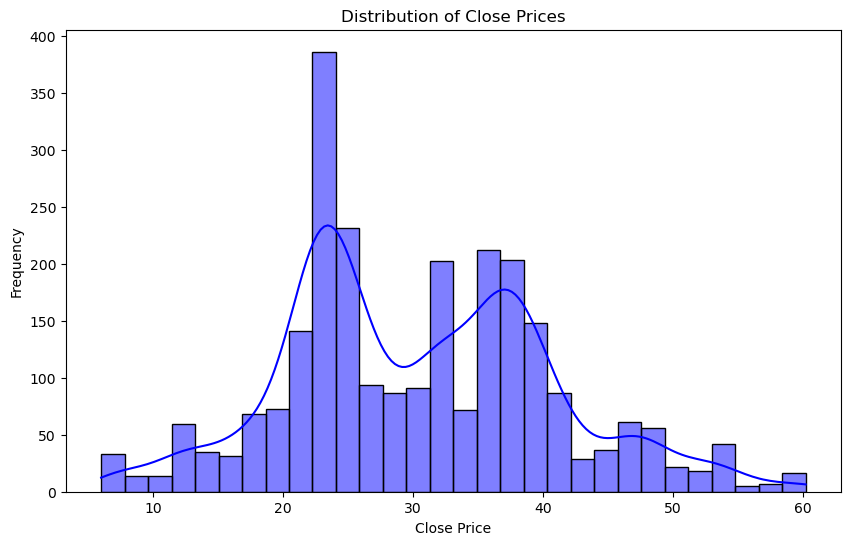

In [30]:
# Visualization 1: Stock price (Close price) distribution
plt.figure(figsize=(10, 6))
sns.histplot(df["Close"], bins=30, kde=True, color="blue")
plt.title("Distribution of Close Prices")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

C:\Users\19793\AppData\Local\Temp\ipykernel_14668\2157369200.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Stock change", palette="coolwarm")


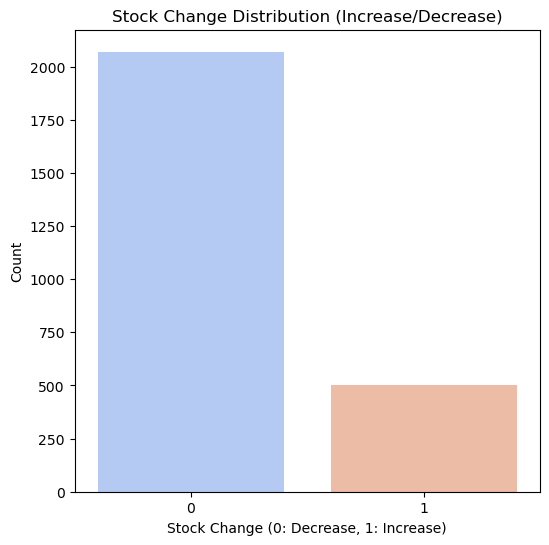

In [31]:
# Visualization 2: Stock price changes (Increase/Decrease) distribution
if "Stock change" in df.columns:
    plt.figure(figsize=(6, 6))
    sns.countplot(data=df, x="Stock change", palette="coolwarm")
    plt.title("Stock Change Distribution (Increase/Decrease)")
    plt.xlabel("Stock Change (0: Decrease, 1: Increase)")
    plt.ylabel("Count")
    plt.show()

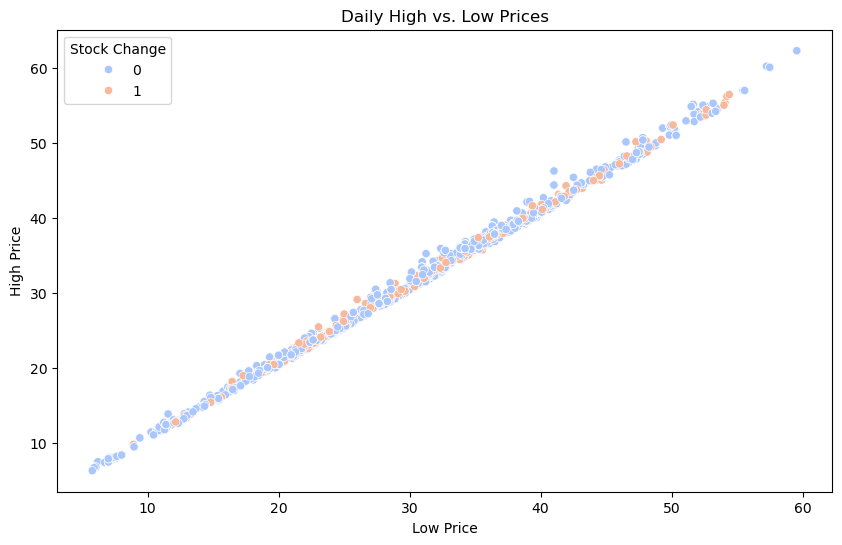

In [32]:
# Visualization 3: Daily high vs. low prices
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Low", y="High", hue="Stock change", palette="coolwarm")
plt.title("Daily High vs. Low Prices")
plt.xlabel("Low Price")
plt.ylabel("High Price")
plt.legend(title="Stock Change")
plt.show()

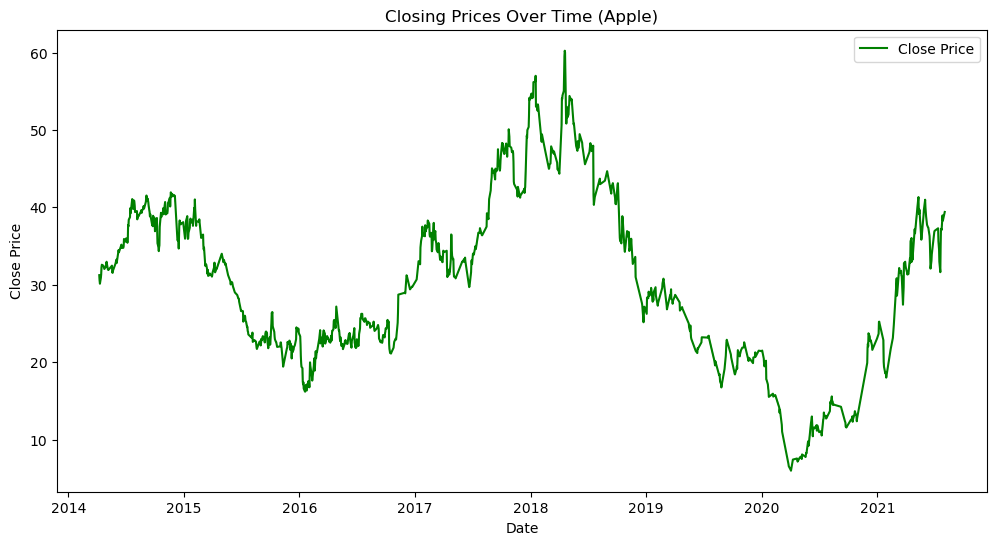

In [33]:
# Visualization 4: Line plot of closing prices over time
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="Date", y="Close", label="Close Price", color="green")
    plt.title("Closing Prices Over Time (Apple)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()


Statistics of Text Word Count:
count     2574.000000
mean       765.514763
std       1125.123142
min         23.000000
25%        389.000000
50%        592.500000
75%        850.000000
max      14025.000000
Name: Word Count, dtype: float64


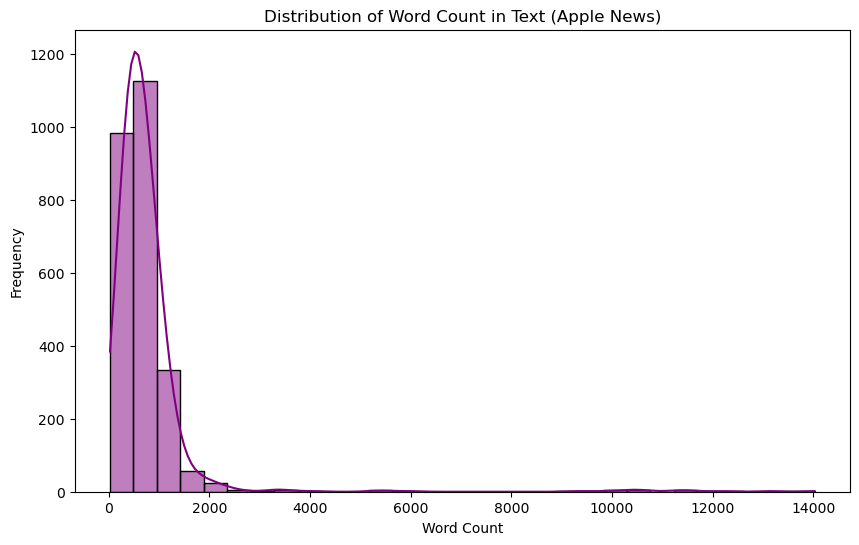

In [34]:
# Text Data Summary: Word Count Distribution
if "Text" in df.columns:
    df["Word Count"] = df["Text"].apply(lambda x: len(str(x).split()))
    print("\nStatistics of Text Word Count:")
    print(df["Word Count"].describe())

    # Visualization 5: Word Count Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["Word Count"], bins=30, kde=True, color="purple")
    plt.title("Distribution of Word Count in Text (Apple News)")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.show()

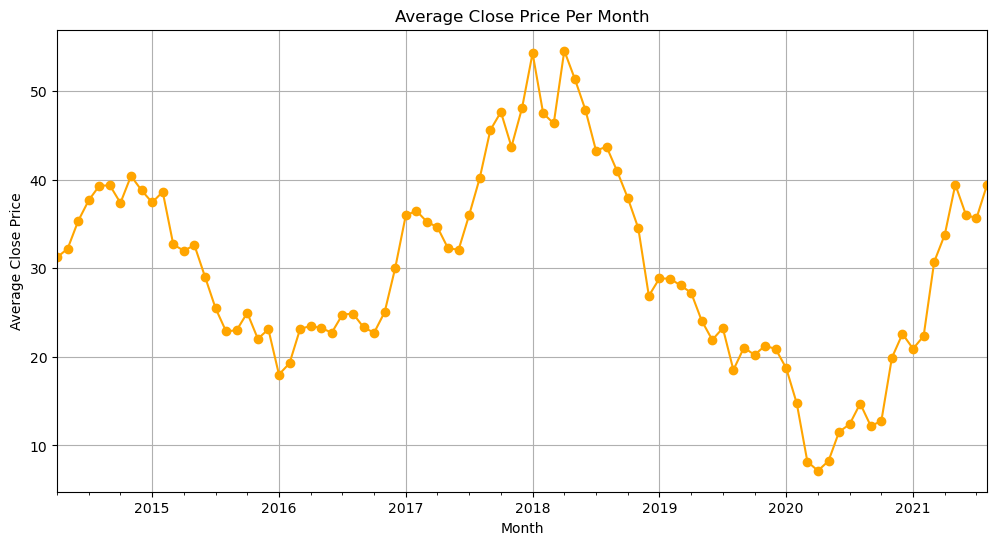

In [35]:
# Additional: Average Close Price Per Month
if "Date" in df.columns:
    df["Month"] = df["Date"].dt.to_period("M")
    avg_close_per_month = df.groupby("Month")["Close"].mean()

    plt.figure(figsize=(12, 6))
    avg_close_per_month.plot(kind="line", marker="o", color="orange")
    plt.title("Average Close Price Per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Close Price")
    plt.grid()
    plt.show()

In [39]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import torch.nn as nn

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define tokenizer and load the saved model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define the custom model
class ModifiedAttentionModel(torch.nn.Module):
    def __init__(self, base_model):
        super(ModifiedAttentionModel, self).__init__()
        self.base_model = base_model
        self.attention_layer = torch.nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze embeddings and encoder layers
            outputs = self.base_model(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        attention_scores = self.attention_layer(hidden_states).squeeze(-1)
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
        context_vector = torch.matmul(attention_weights.unsqueeze(1), hidden_states).squeeze(1)
        return context_vector

# Load the trained model
base_model = BertModel.from_pretrained("bert-base-uncased")
model = ModifiedAttentionModel(base_model)
model.load_state_dict(torch.load("modified_attention_model.pth", map_location=device))
model.eval()
model.to(device)

C:\Users\19793\AppData\Local\Temp\ipykernel_14668\3035151546.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("modified_attention_model.

ModifiedAttentionModel(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [40]:
# Define dataset for embedding extraction
class GistEmbeddingDataset(Dataset):
    def __init__(self, texts, dates, tokenizer, max_len=512):
        self.texts = texts
        self.dates = dates
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        date = self.dates[idx]
        gist = f"[GIST] [DATE] {date}"

        encoding = self.tokenizer.encode_plus(
            gist + " " + text,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
        }

# Load train and test data
train_data = pd.read_csv("train_stock_news.csv")
test_data = pd.read_csv("test_stock_news.csv")

# Split validation set from the training set
val_split = 0.2

# Calculate labels
train_labels = (train_data["Close"].diff().fillna(0) > 0).astype(int).tolist()
test_labels = (test_data["Close"].diff().fillna(0) > 0).astype(int).tolist()

train_texts = train_data["Text"].tolist()
train_dates = train_data["Date"].tolist()

train_texts, val_texts, train_dates, val_dates, train_labels, val_labels = train_test_split(
    train_texts, train_dates, train_labels, test_size=val_split, random_state=42
)

test_texts = test_data["Text"].tolist()
test_dates = test_data["Date"].tolist()

# Create datasets and dataloaders
train_dataset = GistEmbeddingDataset(train_texts, train_dates, tokenizer)
val_dataset = GistEmbeddingDataset(val_texts, val_dates, tokenizer)
test_dataset = GistEmbeddingDataset(test_texts, test_dates, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = torch.tensor(train_labels[:len(batch["input_ids"])]).to(device)
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

Training Epoch 1:  40%|███▉      | 51/129 [13:27<20:25, 15.71s/it]

In [ ]:

# Evaluation
def evaluate_model(model, dataloader, labels):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names=["Down/No Change", "Up"]))
    return predictions

# Evaluate on validation set
val_predictions = evaluate_model(model, val_loader, val_labels)

# Evaluate on test set
test_predictions = evaluate_model(model, test_loader, test_labels)


In [ ]:
# Save predictions
output = pd.DataFrame(test_data)
output["Predicted Label"] = test_predictions
output.to_csv("stock_price_predictions_bert_only.csv", index=False)
print("Predictions saved to stock_price_predictions_bert_only.csv")